In [4]:
"""
ドライブにアクセスするために、以下のコマンドを実行する。
リンクが出て来るのでアクセス→Googleアカウントでログイン→アクセスの許可→コードが出て来るので、下の入力スペースにコピペ

"""
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

"""
Googledriveのマウントを行う。
Colaboratryにdriveという名のディレクトリをつくり、そこにマイドライブの内容をコピーする形。
頭に"drive"というディレクトリがつくことになる。
"""
!mkdir -p drive
!google-drive-ocamlfuse drive

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [2]:
%pylab inline

import numpy as np
import scipy.stats as stats
import pymc3 as pm
from theano import shared
import theano
import theano.tensor as tt
floatX = "float32"

%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [0]:
import geopandas as gpd

In [9]:
cd drive/car_scotland

/content/drive/car_scotland


In [0]:
test = gpd.read_file(r"src/scotlip/scotlip.shp")

In [11]:
test.head(4)

,CODENO,AREA,PERIMETER,RECORD_ID,DISTRICT,NAME,CODE,CANCER,POP,CEXP,AFF,geometry
0,6126,9.740020e+08,184951.0,1,1,Skye-Lochalsh,w6126,9,28324,1.38,16,"POLYGON ((214091.875 841215.1875, 218829 83109..."
1,6016,1.461990e+09,178224.0,2,2,Banff-Buchan,w6016,39,231337,8.66,16,"POLYGON ((383866 865862, 398721 867484, 409200..."
2,6121,1.753090e+09,179177.0,3,3,Caithness,w6121,11,83190,3.04,10,"POLYGON ((311487 968650, 320989 968653, 320254..."
3,5601,8.985990e+08,128777.0,4,4,Berwickshire,w5601,9,51710,2.53,24,"POLYGON ((377180 672603, 386871.65625 670868.6..."


In [0]:
county = np.array(test.iloc[:,5])
O = np.array(test.iloc[:,7])
N = len(test)
E = np.array(test.iloc[:,9])
logE = np.log(E)

In [0]:
aff = np.array(test.iloc[:,10])
adj = np.array([[5, 9,11,19],[7,10],[6,12],[18,20,28],[1,11,12,13,19],[3, 8],[2,10,13,16,17],[6],[1,11,17,19,23,29],[2, 7,16,22],
                [1, 5, 9,12],[3, 5,11],[5, 7,17,19],[31,32,35],[25,29,50],[7,10,17,21,22,29],[7, 9,13,16,19,29],
                [4,20,28,33,55,56],[1, 5, 9,13,17],[4,18,55],[16,29,50],[10,16],[9,29,34,36,37,39],
                [27,30,31,44,47,48,55,56],[15,26,29],[25,29,42,43],[24,31,32,55],[4,18,33,45],[9,15,16,17,21,23,25,26,34,43,50],
                [24,38,42,44,45,56],[14,24,27,32,35,46,47],[14,27,31,35],[18,28,45,56],[23,29,39,40,42,43,51,52,54],
                [14,31,32,37,46],[23,37,39,41],[23,35,36,41,46],[30,42,44,49,51,54],[23,34,36,40,41],[34,39,41,49,52],
                [36,37,39,40,46,49,53],[26,30,34,38,43,51],[26,29,34,42],[24,30,38,48,49],[28,30,33,56],[31,35,37,41,47,53],
                [24,31,46,48,49,53],[24,44,47,49],[38,40,41,44,47,48,52,53,54],[15,21,29],[34,38,42,54],[34,40,49,54],[41,46,47,49],
                [34,38,49,51,52],[18,20,24,27,56],[18,24,30,33,45,55]])

# Change to Python indexing (i.e. -1)
#　同時に、ウェイト行列も作成。すべて1とする。
weights = []
for i in range(len(adj)):
    ones = list(np.ones(len(adj[i])))
    weights.append(ones)
    for j in range(len(adj[i])):
        adj[i][j] = adj[i][j]-1
        
# spatial weight
weights = np.array([[1,1,1,1],
                    [1,1],
                    [1,1],
                    [1,1,1],
                    [1,1,1,1,1],
                    [1,1],
                    [1,1,1,1,1],
                    [1],
                    [1,1,1,1,1,1],
                    [1,1,1,1],
                    [1,1,1,1],
                    [1,1,1],
                    [1,1,1,1],
                    [1,1,1],
                    [1,1,1],
                    [1,1,1,1,1,1],
                    [1,1,1,1,1,1],
                    [1,1,1,1,1,1],
                    [1,1,1,1,1],
                    [1,1,1],
                    [1,1,1],
                    [1,1],
                    [1,1,1,1,1,1],
                    [1,1,1,1,1,1,1,1],
                    [1,1,1],
                    [1,1,1,1],
                    [1,1,1,1],
                    [1,1,1,1],
                    [1,1,1,1,1,1,1,1,1,1,1],
                    [1,1,1,1,1,1],
                    [1,1,1,1,1,1,1],
                    [1,1,1,1],
                    [1,1,1,1],
                    [1,1,1,1,1,1,1,1,1],
                    [1,1,1,1,1],
                    [1,1,1,1],
                    [1,1,1,1,1],
                    [1,1,1,1,1,1],
                    [1,1,1,1,1],
                    [1,1,1,1,1],
                    [1,1,1,1,1,1,1],
                    [1,1,1,1,1,1],
                    [1,1,1,1],
                    [1,1,1,1,1],
                    [1,1,1,1],
                    [1,1,1,1,1,1],
                    [1,1,1,1,1,1],
                    [1,1,1,1],
                    [1,1,1,1,1,1,1,1,1],
                    [1,1,1],
                    [1,1,1,1],
                    [1,1,1,1],
                    [1,1,1,1],
                    [1,1,1,1,1],
                    [1,1,1,1,1],
                    [1,1,1,1,1,1]])

Wplus = np.asarray([sum(w) for w in weights])

In [22]:
value = np.asarray(np.random.randn(N,), dtype=theano.config.floatX)
Wplus = np.asarray([sum(w) for w in weights])
maxwz = max([sum(w) for w in weights])
N = len(weights)
wmat2 = np.zeros((N, N))
amat2 = np.zeros((N, N), dtype='int32')
for i, a in enumerate(adj):
    amat2[i, a] = 1
    wmat2[i, a] = weights[i]

value = np.asarray(np.random.randn(N,), dtype=theano.config.floatX)

print(np.sum(value*amat2, axis=1)/np.sum(wmat2, axis=1))


def mu_phi(value):
    N = len(weights)
    # Calculate mu based on average of neighbours
    mu = np.array([np.sum(weights[i]*value[adj[i]])/Wplus[i] for i in range(N)])
    return mu

print(mu_phi(value))

[ 0.14755038  1.27902149  0.88194869 -1.49084519  0.85212027 -0.49487956
  0.40600958 -0.20904401  0.88934424 -0.09332515  0.65031857 -0.09370756
  0.63900841  1.09086506  0.79596975  0.81184939  0.28565192 -0.66899787
  0.42316388 -0.85093495  0.50840821  0.72416737  0.5160885  -0.22407475
  0.90632422  0.20393875  0.00604112 -0.04268768  0.04189428  0.21628513
 -0.12519945 -0.16349292 -0.40995711  0.36900755 -0.07712489  0.02935208
  0.77235875  0.06801683  0.7014849   0.29392716  0.5131975   0.19574014
  0.91977224 -0.25945189 -0.36864163  0.54824607  0.18879626 -0.38408112
  0.51334242  0.30895471  0.71183562  0.47438821  0.07244722  0.21798888
 -1.30269512 -0.28337386]
[ 0.14755038  1.27902149  0.88194869 -1.49084519  0.85212027 -0.49487956
  0.40600958 -0.20904401  0.88934424 -0.09332515  0.65031857 -0.09370756
  0.63900841  1.09086506  0.79596975  0.81184939  0.28565192 -0.66899787
  0.42316388 -0.85093495  0.50840821  0.72416737  0.5160885  -0.22407475
  0.90632422  0.20393875 

In [0]:
from theano import scan
floatX = "float32"

from pymc3.distributions import continuous
from pymc3.distributions import distribution

In [0]:
class CAR2(distribution.Continuous):
    """
    Conditional Autoregressive (CAR) distribution

    Parameters
    ----------
    a : adjacency matrix
    w : weight matrix
    tau : precision at each location
    """

    def __init__(self, w, a, tau, *args, **kwargs):
        super(CAR2, self).__init__(*args, **kwargs)
        self.a = a = tt.as_tensor_variable(a)
        self.w = w = tt.as_tensor_variable(w)
        self.tau = tau*tt.sum(w, axis=1)
        self.mode = 0.

    def logp(self, x):
        tau = self.tau
        w = self.w
        a = self.a

        mu_w = tt.sum(x*a, axis=1)/tt.sum(w, axis=1)
        return tt.sum(continuous.Normal.dist(mu=mu_w, tau=tau).logp(x))

In [25]:
with pm.Model() as model2:
    # Vague prior on intercept
    beta0 = pm.Normal('beta0', mu=0.0, tau=1.0e-5)
    # Vague prior on covariate effect
    beta1 = pm.Normal('beta1', mu=0.0, tau=1.0e-5)

    # Random effects (hierarchial) prior
    tau_h = pm.Gamma('tau_h', alpha=3.2761, beta=1.81)
    # Spatial clustering prior
    tau_c = pm.Gamma('tau_c', alpha=1.0, beta=1.0)

    # Regional random effects
    theta = pm.Normal('theta', mu=0.0, tau=tau_h, shape=N)
    mu_phi = CAR2('mu_phi', w=wmat2, a=amat2, tau=tau_c, shape=N)

    # Zero-centre phi
    phi = pm.Deterministic('phi', mu_phi-tt.mean(mu_phi))

    # Mean model
    mu = pm.Deterministic('mu', tt.exp(logE + beta0 + beta1*aff + theta + phi))

    # Likelihood
    Yi = pm.Poisson('Yi', mu=mu, observed=O)

    # Marginal SD of heterogeniety effects
    sd_h = pm.Deterministic('sd_h', tt.std(theta))
    # Marginal SD of clustering (spatial) effects
    sd_c = pm.Deterministic('sd_c', tt.std(phi))
    # Proportion sptial variance
    alpha = pm.Deterministic('alpha', sd_c/(sd_h+sd_c))

    trace2 = pm.sample(int(3e3), cores=int(2), tune=int(1000), nuts_kwargs={'max_treedepth': 15})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_phi, theta, tau_c, tau_h, beta1, beta0]
Sampling 2 chains:  12%|█▏        | 962/8000 [01:19<26:53,  4.36draws/s]

Sampling 2 chains: 100%|██████████| 8000/8000 [6:52:39<00:00,  7.17s/draws]


/usr/local/lib/python3.6/dist-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/usr/local/lib/python3.6/dist-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))
There were 356 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3460855792444846, but should be close to 0.8. Try to increase the number of tuning steps.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. I

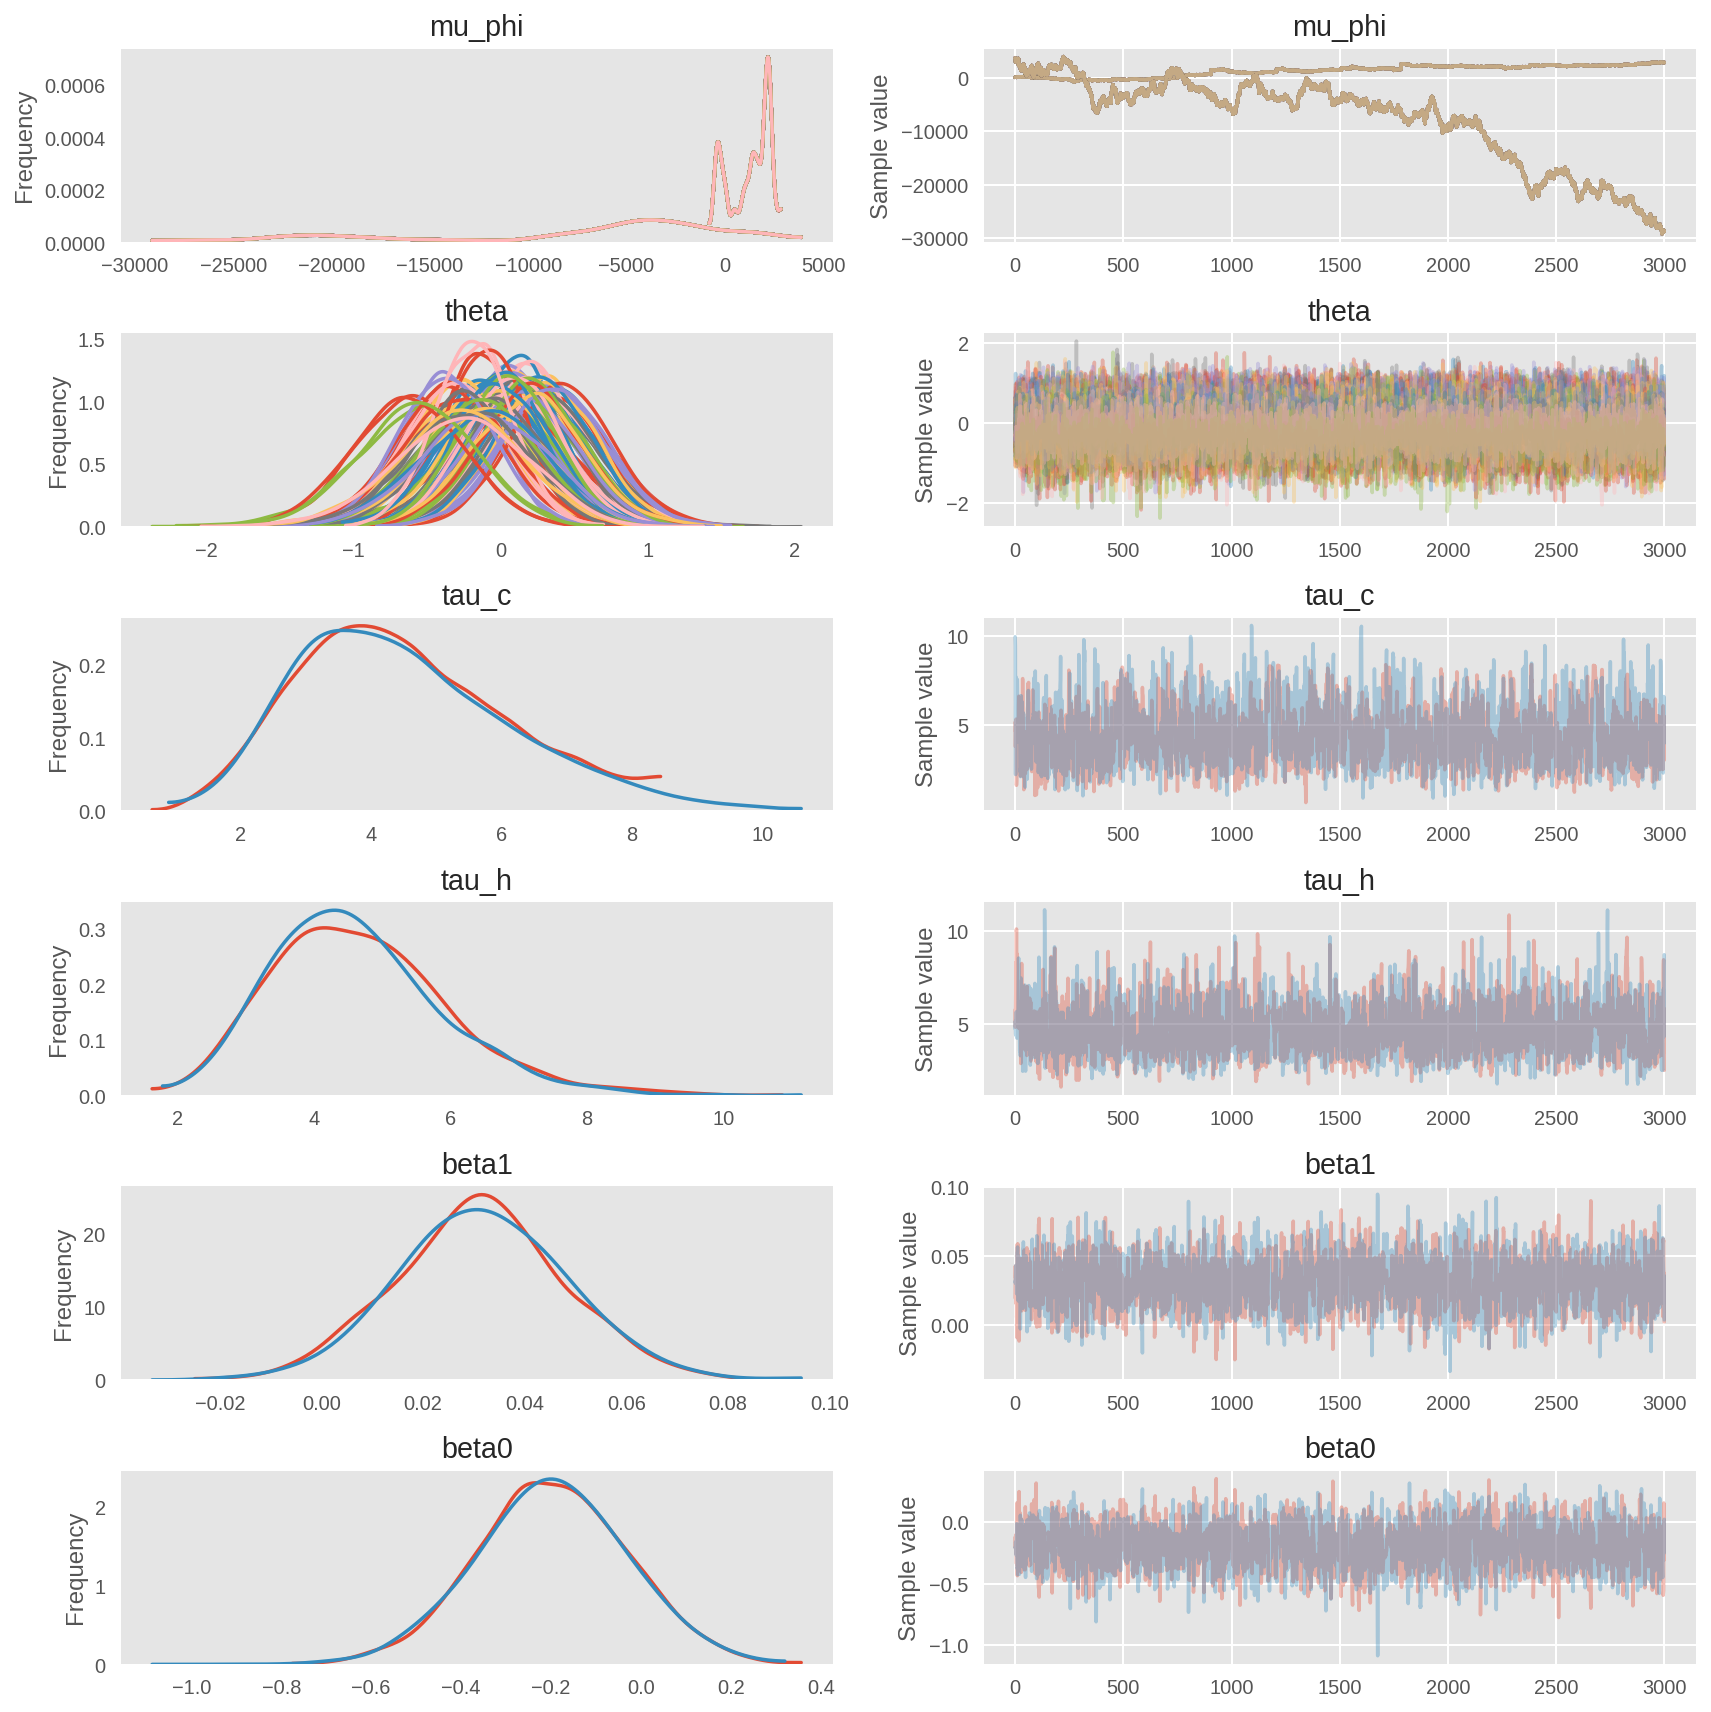

In [27]:
pm.traceplot(trace2, varnames=["mu_phi", "theta", "tau_c", "tau_h", "beta1", "beta0"]);

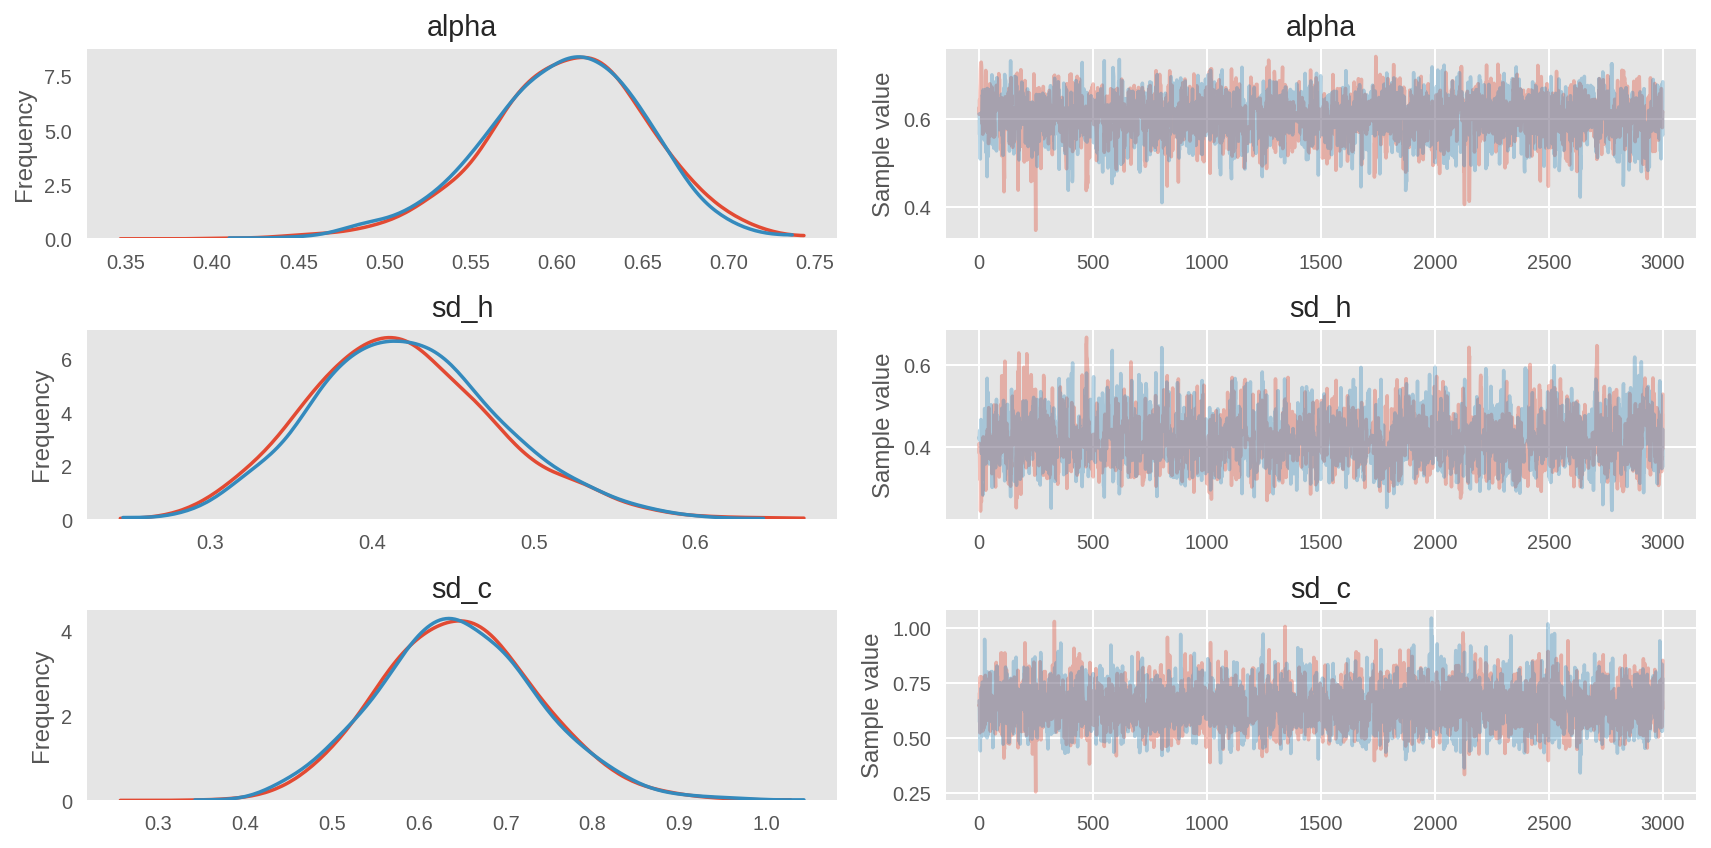

In [29]:
pm.traceplot(trace2, varnames=['alpha', 'sd_h', 'sd_c']);

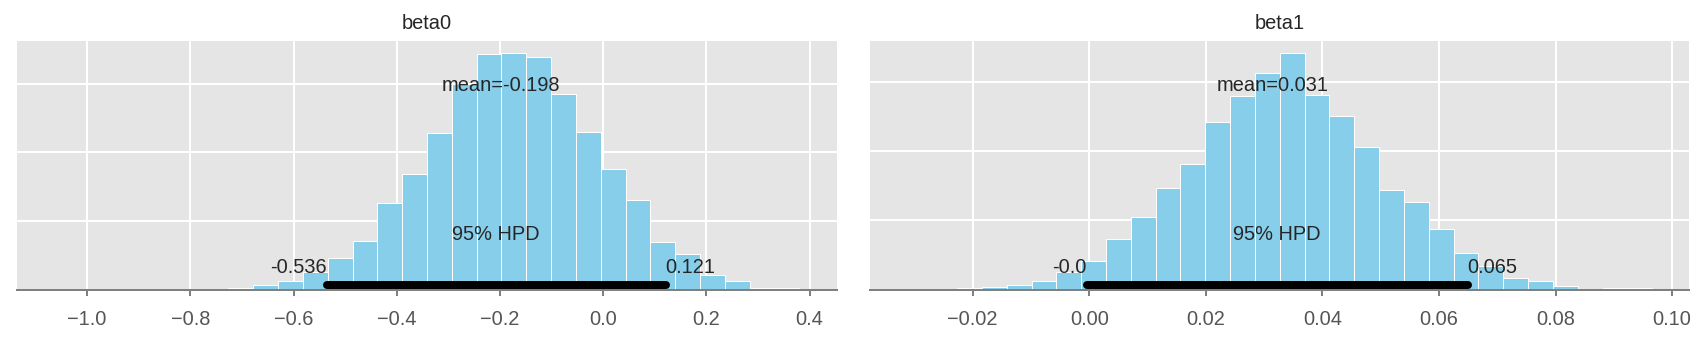

In [32]:
pm.plot_posterior(trace2, varnames=["beta0", "beta1"]);

In [43]:
SMR_hat = logE -0.198 + 0.031*aff
test["SMR_hat"] = exp(SMR_hat)/E
test["SMR"] = O/E
test.head(5)

,CODENO,AREA,PERIMETER,RECORD_ID,DISTRICT,NAME,CODE,CANCER,POP,CEXP,AFF,geometry,SMR_hat,SMR
0,6126,9.740020e+08,184951.0,1,1,Skye-Lochalsh,w6126,9,28324,1.38,16,"POLYGON ((214091.875 841215.1875, 218829 83109...",1.347162,6.521739
1,6016,1.461990e+09,178224.0,2,2,Banff-Buchan,w6016,39,231337,8.66,16,"POLYGON ((383866 865862, 398721 867484, 409200...",1.347162,4.503464
2,6121,1.753090e+09,179177.0,3,3,Caithness,w6121,11,83190,3.04,10,"POLYGON ((311487 968650, 320989 968653, 320254...",1.118513,3.618421
3,5601,8.985990e+08,128777.0,4,4,Berwickshire,w5601,9,51710,2.53,24,"POLYGON ((377180 672603, 386871.65625 670868.6...",1.726334,3.557312
4,6125,5.109870e+09,580792.0,5,5,Ross-Cromarty,w6125,15,129271,4.26,10,"POLYGON ((278680.0625 882371.8125, 294960 8878...",1.118513,3.521127


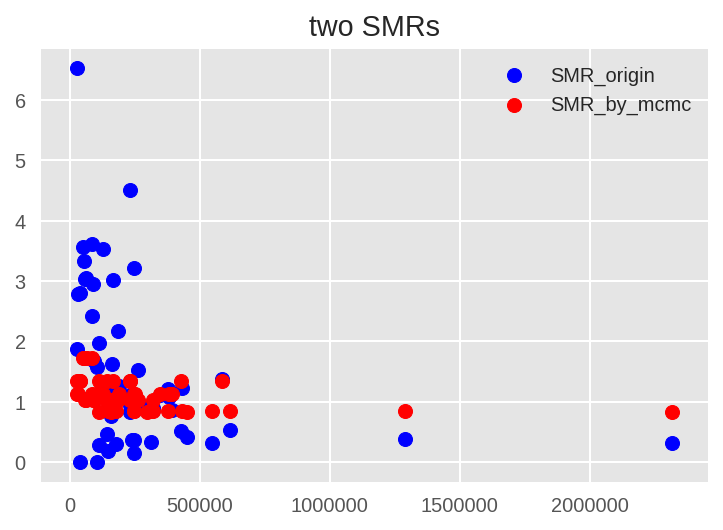

In [44]:
from matplotlib import pyplot
pyplot.scatter(test["POP"], test["SMR"],   c='b', label = 'SMR_origin')
pyplot.scatter(test["POP"], test["SMR_hat"],   c='r', label = 'SMR_by_mcmc')
pyplot.legend()
pyplot.title("two SMRs")
pyplot.show()

In [0]:
test.to_csv(r"dev/scotlip_MCMCed.csv")

In [34]:
map_estimate = pm.find_MAP(model=model2)

map_estimate

logp = -91.629, ||grad|| = 0.23832: 100%|██████████| 275/275 [00:00<00:00, 916.16it/s] 


{'alpha': array(0.73997171),
 'beta0': array(-0.20511803),
 'beta1': array(0.03970117),
 'mu': array([ 6.34511765, 36.10670356, 10.00704227,  6.44140109, 13.96665951,
         9.97432649, 23.77151802,  6.23181871,  4.3452721 , 19.41868948,
        12.19999643,  6.23049653,  2.89348779,  6.05429359, 13.46009664,
         9.92333951,  2.27813305,  4.79061274, 10.90136824,  5.5848706 ,
        15.05259686, 35.54822158, 10.22082561,  4.84337318, 17.19486007,
        12.36844431,  5.39572044,  9.08525866, 17.39658647,  9.35182463,
         3.86770942,  3.98558856,  6.92574534,  6.987559  , 10.09266063,
         7.13249675, 10.95569826,  5.75265255,  7.01934271,  2.91808816,
        10.00623721, 11.6992658 ,  4.33568134,  6.64140325, 22.71750295,
         4.75903549,  2.6616036 ,  4.13554095, 31.0541403 , 11.35289176,
         1.66162844,  1.6301181 ,  2.46265813,  2.89572075,  3.57349284,
         1.38951989]),
 'mu_phi': array([ 0.85874578,  0.73914913,  0.91092638, -0.0413228 ,  0.9034525